## Playing the Dice Blackjack with Q-learning agent

**Prepared by:** Makar Korchagin, Ilya Zherebtsov, Rinat Prochii, Aibek Akhmetkazy and Mukhail Gubanov

In [1]:
import os

import gymnasium as gym
import numpy as np
from tqdm import trange

from src.agent import QLearningAgent
from src.env import DiceBlackJack
from src.visualization import (
    convert_q_table,
    mp4_to_gif,
    plot_policy_tables_18,
    show_inference_stats,
    show_training_stats,
)


In [2]:
os.makedirs("./analysis", exist_ok=True)

You may unveil the training process by redirecting the logs to the file and analyse then later.

In [3]:
import logging

logging.basicConfig(
    level=logging.WARNING,
    filemode="w",
    filename="./analysis/training.log",
    format="[%(levelname)s] %(message)s",
)
logging.logProcesses = False

### Environment

The Balckjack game is the game, that use a pair of dice instead of cards as a source of randomness. To get familiar with the game rules, you may see the original source at this [link](https://www.chessandpoker.com/dice_blackjack.html).

The Dice Blackjack has a state vector $\bold{s} = [p, d_1, d_2] \in \mathbb{S}$, 

where:

$p \in [0, 27] \subset \mathbb{N}_0$ - the sum of the previous rolls;

$d_1, d_2 \in [0, 6] \subset \mathbb{N}_0$ - the rolled values of first and second die (0 value is used to indicate final states, when no rolling is available).

The action space consists of 6 actions: 

0 - hit the first die (**H1**);
1 - hit the second die (**H2**);
2 - hit the sum (**HΣ**);

3 - stack the first die (**S1**);
4 - stack the second die (**S2**);
5 - stack the sum (**SΣ**).

The game ends with on of four possible rewards:

-1 - the player got busted (scored more than 21 points) or got less points than the dealer;
0 - the game ended with a tie;
1 - the player won over the dealer or dealer got busted;
2 - the player rolled a Blackjack combination (2 double values in first two rolls).

You may play the game by launching the environment file `/src/env.py` directly.

In [4]:
learning_rate = 0.10
n_episodes = 500_000

env = DiceBlackJack()
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent = QLearningAgent(env=env, n_episodes=n_episodes, seed=0x42)

### Training
Using the wrapper from gymnasium library, we can train the model and plot the training in two lines. To keep the balance between policy breadth and its quality, we have defined non-linear exploration rate decay

$$\varepsilon(r) = \max(1 - \sqrt[3]{r}, 0.02),$$

where $r \in [0, 1] \subset \mathbb{R}$ - the normalized training progress.

In [5]:
decay = lambda x: max(1 - np.power(x, 0.33), 0.02)
training_error = agent.train(learning_rate=learning_rate, epsilon_decay=decay)

Training: 100%|██████████| 500000/500000 [03:52<00:00, 2153.04it/s]


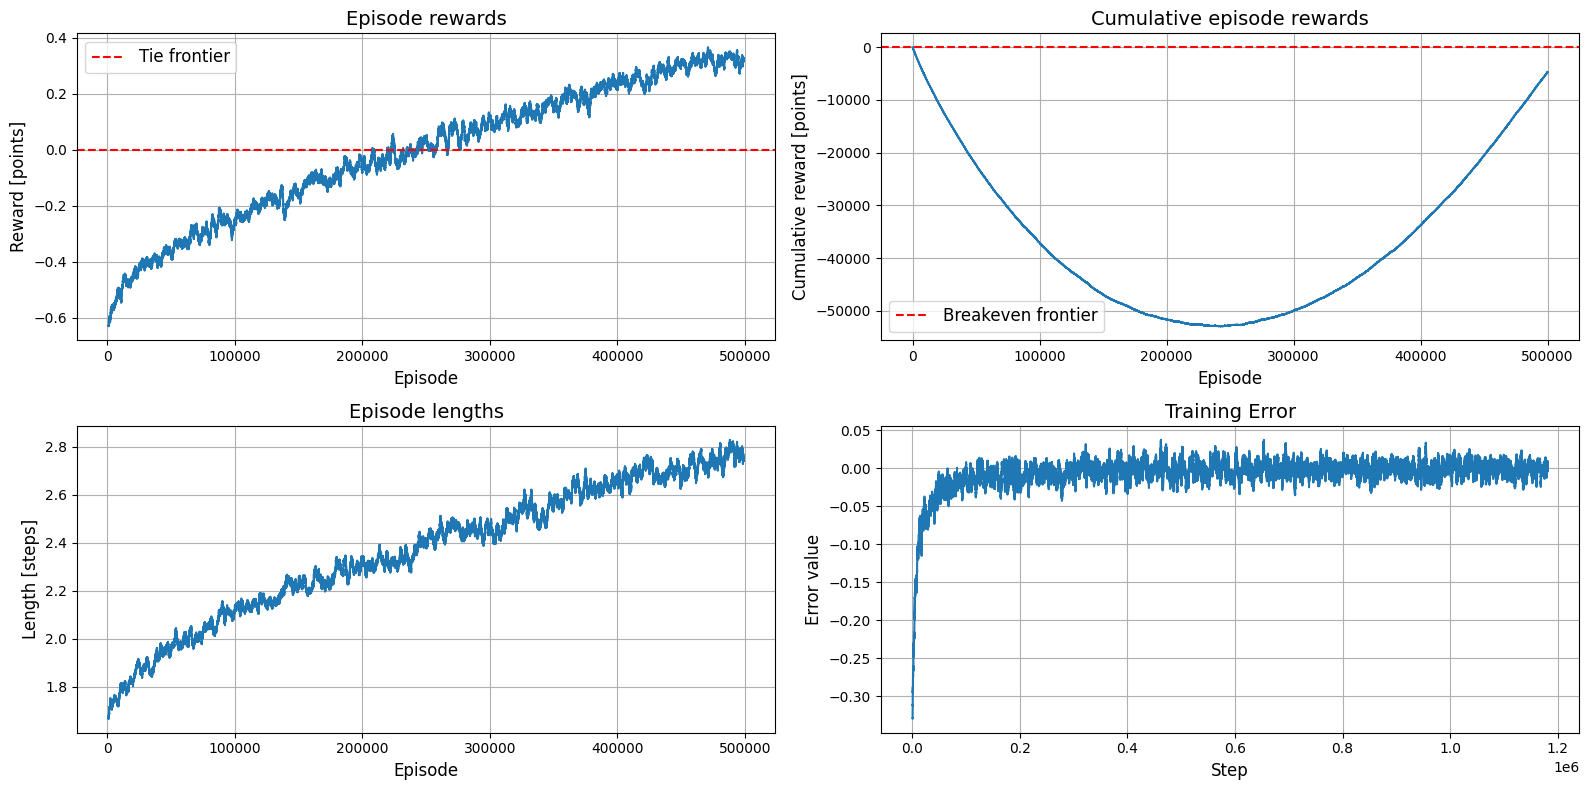

In [6]:
rolling_length = 2000
figure = show_training_stats(env, training_error, rolling_length)
figure.savefig("./analysis/training.jpg", dpi=300)

As we can see, the agent has acquired the policy, that allows to get the average score above 0.3. In terms of game, the average agent's bid multplication factor would be 1.3.

### Policy representation
By converting the Q-table to the heatmaps, we reveal the agent's logic that it has obtained during the training.

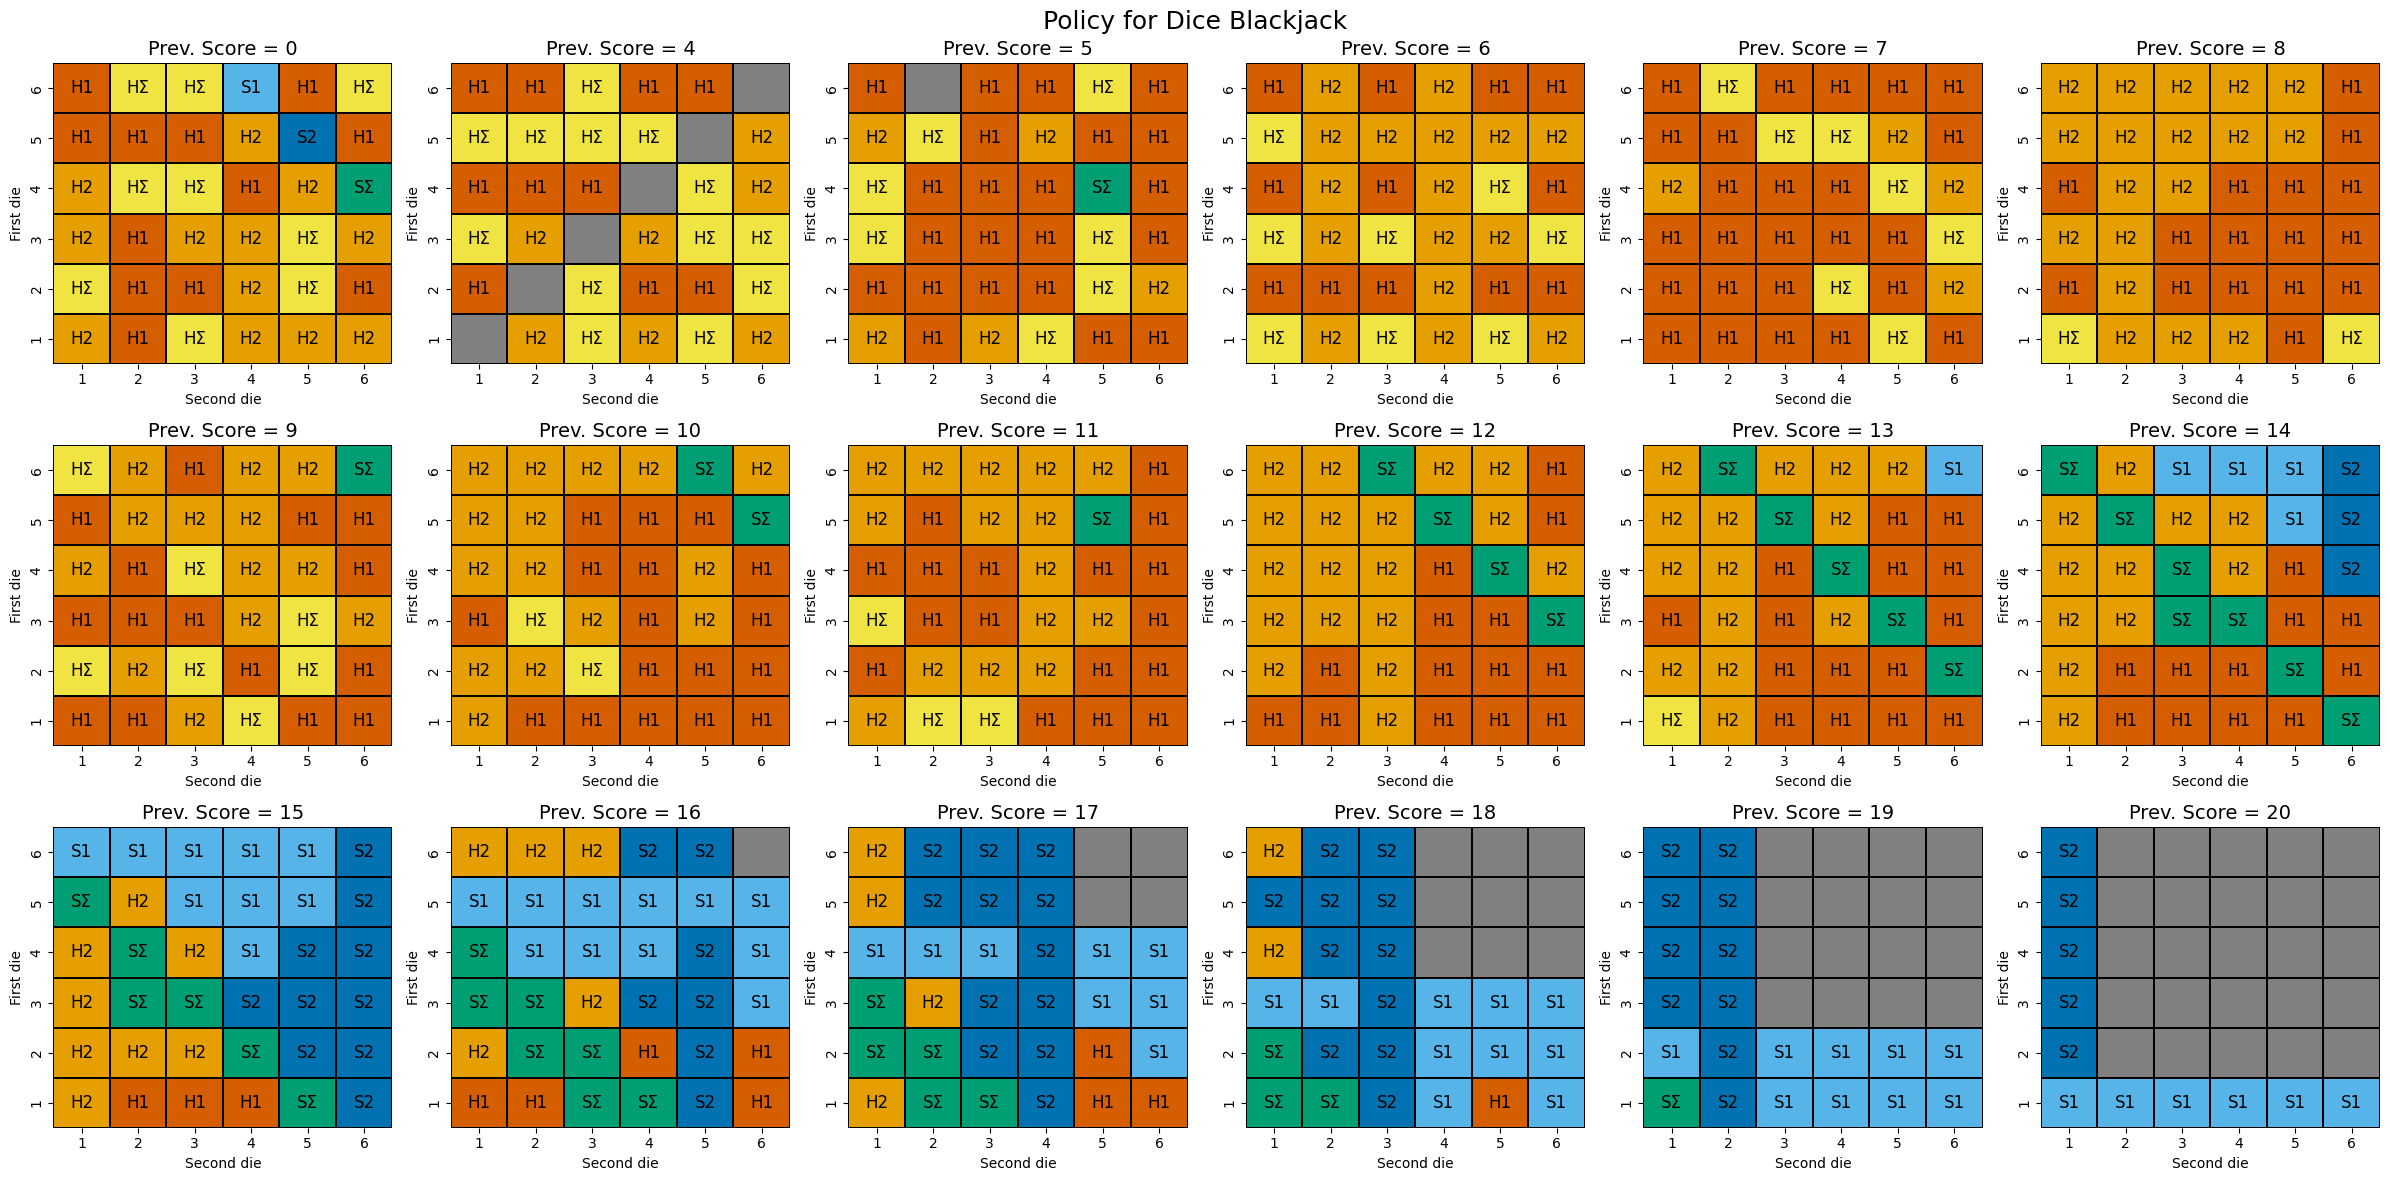

In [7]:
action_info = {
    0: ("H1", "#D55E00"),
    1: ("H2", "#E69F00"),
    2: ("HΣ", "#F0E442"),
    3: ("S1", "#56B4E9"),
    4: ("S2", "#0072B2"),
    5: ("SΣ", "#009E73"),
}

action_table = convert_q_table(agent.get_q_table())
figure = plot_policy_tables_18(action_table, action_info)
figure.savefig("./analysis/policy.jpg", dpi=300)

You may try the policy by yourself and validate it manually.

### Inference

For the inference, we have played another 50.000 episodes and recorded 60 first steps to the `.gif` file.

In [8]:
n_episodes = 50_000
env = DiceBlackJack(render_mode="rgb_array")
env = gym.wrappers.RecordVideo(
    env,
    video_folder="./analysis",
    fps=1,
    video_length=60,
    episode_trigger=lambda x: x == 0,
    name_prefix="dice-blackjack",
)
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

c:\Users\mekor\Documents\Skoltech\Term-7\RL\dice-blackjack-mdp\.venv\Lib\site-packages\gymnasium\wrappers\rendering.py:283: UserWarning: WARN: Overwriting existing videos at c:\Users\mekor\Documents\Skoltech\Term-7\RL\dice-blackjack-mdp\analysis folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [9]:
for _ in trange(n_episodes, desc="Inference"):
    obs, _ = env.reset()
    done = False
    while not done:
        action = agent.respond(obs)
        obs, reward, done, _, _ = env.step(action)

Inference: 100%|██████████| 50000/50000 [00:21<00:00, 2272.97it/s]


In [10]:
mp4_to_gif(folder="./analysis")

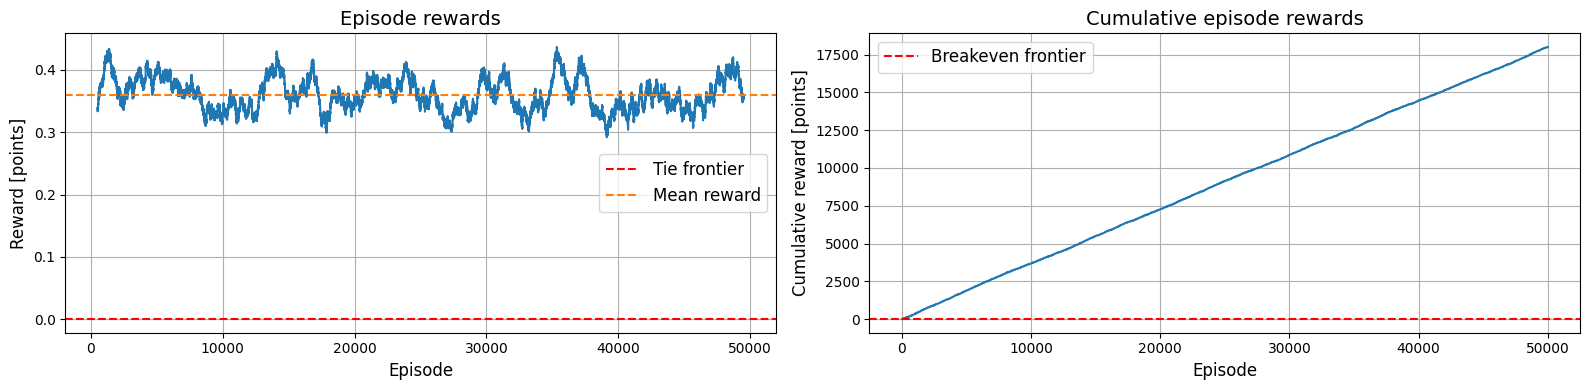

In [11]:
figure = show_inference_stats(env)
figure.savefig("./analysis/validation.jpg", dpi=300)

It is evident, that the agent's policy has the positive mean reward.